In [190]:
from typing import Optional
from omegaconf import DictConfig

import logging
import torch

from tabularbench.core.enums import DatasetSize, ModelName, Task
from tabularbench.core.get_model import get_model
from tabularbench.core.get_trainer import get_trainer

from tabularbench.data.dataset_openml import OpenMLDataset
from tabularbench.results.run_metrics import RunMetrics
from tabularbench.utils.config_run import ConfigRun
from tabularbench.utils.set_seed import set_seed
from tabularbench.core.run_experiment import run_experiment


cfg = ConfigRun(
    output_dir = "output_run_experiment",
    device = torch.device("cuda:0"),
    model_name = ModelName.FOUNDATION,
    seed = 0,
    task = Task.CLASSIFICATION,
    dataset_size = DatasetSize.MEDIUM,
    openml_dataset_id = 44156,
    openml_dataset_name = "electricity",
    hyperparams = DictConfig({
        'n_features': 100,
        'n_classes': 10,
        'dim': 512,
        'n_layers': 12,
        'n_heads': 4,
        'attn_dropout': 0.0,
        'y_as_float_embedding': True,
        'linear_attention': False,
        'max_samples_support': 10000,
        'max_samples_query': 10000,
        'max_epochs': 300,
        'optimizer': 'adamw',
        'lr': 1.e-5,
        'weight_decay': 0,
        'lr_scheduler': False,
        'lr_scheduler_patience': 30,
        'early_stopping_patience': 40,
        'use_pretrained_weights': True,
        'path_to_weights': "tabularbench/weights/foundation_forest.pt",
        'n_ensembles': 1,
        'use_quantile_transformer': True,
        'use_feature_count_scaling': True
    })
)

In [191]:
import numpy as np

dataset = OpenMLDataset(cfg.openml_dataset_id, cfg.task, cfg.dataset_size)
metrics = RunMetrics()

x_train, x_val, x_test, y_train, y_val, y_test, categorical_indicator = next(dataset.split_iterator())

# variables 0 and 3 are the most important ones (as selected by random forest feature importance)

x_train = x_train[:, [0, 3]]
x_val = x_val[:, [0, 3]]
x_test = x_test[:, [0, 3]]

In [192]:
cfg.hyperparams['path_to_weights'] = "tabularbench/weights/foundation_forest.pt"

model = get_model(cfg, x_train, y_train, categorical_indicator)
trainer = get_trainer(cfg, model)
trainer.train(x_train, y_train)

loss_train, score_train = trainer.test(x_train, y_train, x_train, y_train)
loss_val, score_val = trainer.test(x_train, y_train, x_val, y_val)
loss_test, score_test = trainer.test(x_train, y_train, x_test, y_test)

score_test

2024-02-05 16:58:37.834 | INFO     | tabularbench.core.trainer_finetune:train:85 - Epoch 000 | Train loss: 0.4436 | Train score: 0.7844 | Val loss: 0.4371 | Val score: 0.7995
2024-02-05 16:58:39.218 | INFO     | tabularbench.core.trainer_finetune:train:85 - Epoch 001 | Train loss: 0.4172 | Train score: 0.7944 | Val loss: 0.4346 | Val score: 0.7930
2024-02-05 16:58:40.641 | INFO     | tabularbench.core.trainer_finetune:train:85 - Epoch 002 | Train loss: 0.4293 | Train score: 0.7969 | Val loss: 0.4361 | Val score: 0.7920
2024-02-05 16:58:41.665 | INFO     | tabularbench.core.trainer_finetune:train:85 - Epoch 003 | Train loss: 0.4290 | Train score: 0.7962 | Val loss: 0.4313 | Val score: 0.7965
2024-02-05 16:58:43.073 | INFO     | tabularbench.core.trainer_finetune:train:85 - Epoch 004 | Train loss: 0.3995 | Train score: 0.8194 | Val loss: 0.4242 | Val score: 0.8030
2024-02-05 16:58:44.502 | INFO     | tabularbench.core.trainer_finetune:train:85 - Epoch 005 | Train loss: 0.4256 | Train sco

0.8220449686050415

In [193]:
cfg.hyperparams['path_to_weights'] = "tabularbench/weights/foundation_pfn.pt"

model_pfn = get_model(cfg, x_train, y_train, categorical_indicator)
trainer_pfn = get_trainer(cfg, model_pfn)
trainer_pfn.train(x_train, y_train)

loss_train, score_train = trainer_pfn.test(x_train, y_train, x_train, y_train)
loss_val, score_val = trainer_pfn.test(x_train, y_train, x_val, y_val)
loss_test, score_test = trainer_pfn.test(x_train, y_train, x_test, y_test)

score_test

2024-02-05 17:03:35.297 | INFO     | tabularbench.core.trainer_finetune:train:85 - Epoch 000 | Train loss: 0.4574 | Train score: 0.7812 | Val loss: 0.4275 | Val score: 0.7995
2024-02-05 17:03:36.716 | INFO     | tabularbench.core.trainer_finetune:train:85 - Epoch 001 | Train loss: 0.4797 | Train score: 0.7619 | Val loss: 0.4237 | Val score: 0.8010
2024-02-05 17:03:38.157 | INFO     | tabularbench.core.trainer_finetune:train:85 - Epoch 002 | Train loss: 0.4216 | Train score: 0.8012 | Val loss: 0.4186 | Val score: 0.7990
2024-02-05 17:03:39.603 | INFO     | tabularbench.core.trainer_finetune:train:85 - Epoch 003 | Train loss: 0.4396 | Train score: 0.7819 | Val loss: 0.4172 | Val score: 0.8050
2024-02-05 17:03:41.059 | INFO     | tabularbench.core.trainer_finetune:train:85 - Epoch 004 | Train loss: 0.4422 | Train score: 0.7806 | Val loss: 0.4159 | Val score: 0.8030
2024-02-05 17:03:42.492 | INFO     | tabularbench.core.trainer_finetune:train:85 - Epoch 005 | Train loss: 0.4207 | Train sco

0.8020268678665161

In [194]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, alpha=1e-4)
mlp.fit(x_train, y_train)
mlp.score(x_test, y_test)

0.7894340758579169

In [195]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(x_train, y_train)
clf.score(x_test, y_test)


0.8693558097531607

In [196]:
clf.feature_importances_

array([0.41942146, 0.58057854])

In [197]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

coolwarm = plt.get_cmap('coolwarm')
coolwarm_trunc = truncate_colormap(coolwarm, 0.1, 0.9)

In [198]:
import einx

x1 = (np.arange(1000) / 100 - 0.5) * 6
x2 = (np.arange(1000) / 100 - 0.5) * 6

x_mesh1, x_mesh2 = np.meshgrid(x1, x2)

x_mesh1_col = einx.rearrange('h w -> (h w)', x_mesh1)
x_mesh2_col = einx.rearrange('h w -> (h w)', x_mesh2)

x_grid = np.zeros((1000000, x_test.shape[1]))
x_grid[:, 0] = x_mesh1_col
x_grid[:, 1] = x_mesh2_col

Text(0.5, 1.0, 'Random Forest (87% acc)')

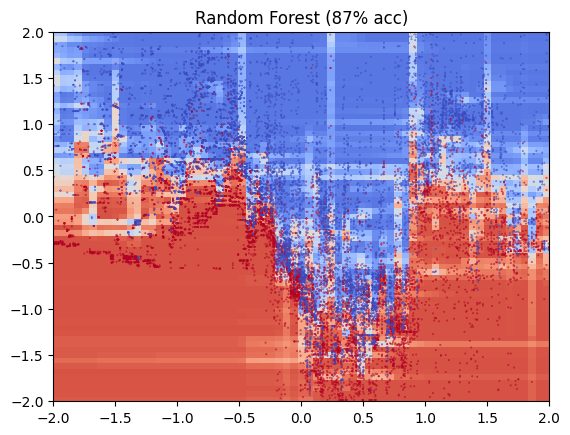

In [209]:
import matplotlib.pyplot as plt

preds = clf.predict_proba(x_grid)
preds = einx.rearrange('(h w) c -> h w c', preds, w=1000)

plt.pcolormesh(x_mesh1, x_mesh2, preds[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)
plt.title("Random Forest (87% acc)")

Text(0.5, 1.0, 'MLP (79% acc)')

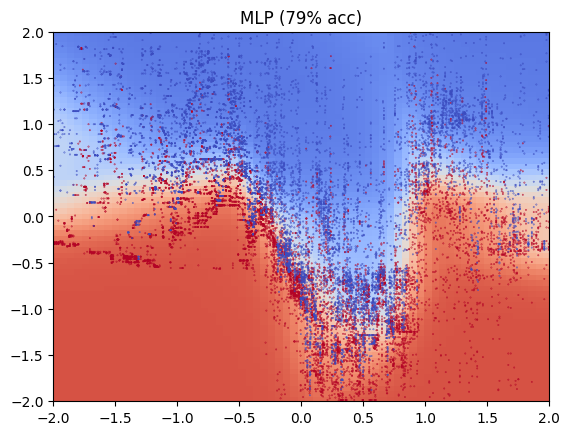

In [208]:
import matplotlib.pyplot as plt

preds = mlp.predict_proba(x_grid)
preds = einx.rearrange('(h w) c -> h w c', preds, w=1000)

plt.pcolormesh(x_mesh1, x_mesh2, preds[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)

plt.title("MLP (79% acc)")

In [203]:
preds_pfn_raw = trainer_pfn.predict(x_train, y_train, x_grid)
preds_pfn = einx.softmax('n [c]', preds_pfn_raw)
preds_pfn = einx.rearrange('(h w) c -> h w c', preds_pfn, w=1000)


Text(0.5, 1.0, 'Foundation PFN (80% acc)')

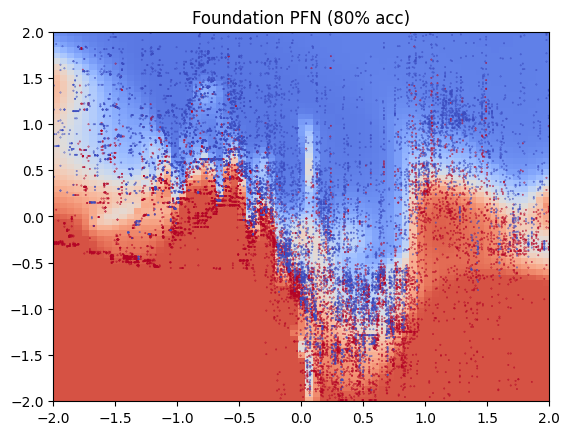

In [211]:
import matplotlib.pyplot as plt

plt.pcolormesh(x_mesh1, x_mesh2, preds_pfn[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)
plt.title("Foundation PFN (80% acc)")

In [213]:
preds_forest_raw = trainer.predict(x_train, y_train, x_grid)
preds_forest = einx.softmax('n [c]', preds_forest_raw)
preds_forest = einx.rearrange('(h w) c -> h w c', preds_forest, w=1000)

Text(0.5, 1.0, 'Foundation Forest (82% acc)')

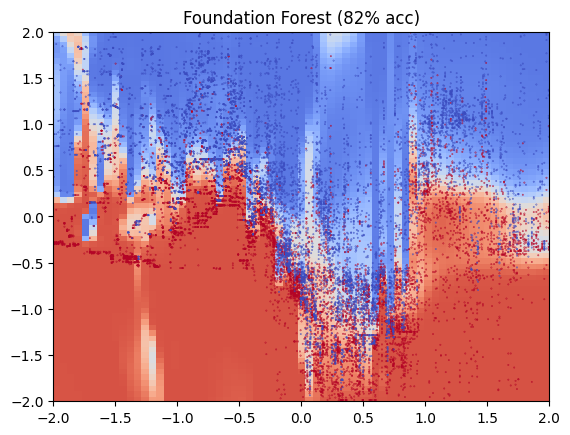

In [214]:
import matplotlib.pyplot as plt

plt.pcolormesh(x_mesh1, x_mesh2, preds_forest[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)

plt.title("Foundation Forest (82% acc)")